In [1]:
from cuml.cluster import HDBSCAN
from cuml.cluster import DBSCAN
from cuml.manifold import UMAP
from cuml.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from cuml.metrics.pairwise_distances import pairwise_distances

In [2]:
import pandas as pd
import numpy as np
import hdbscan
import sklearn
import datetime
import stopwordsiso as sw
import igraph
import matplotlib.pyplot as plt
import leidenalg as la

In [3]:
# Loading all the fragments of the SBERT embedding.
st = datetime.datetime.now()
for i in range(101):
    if i == 0:
        texts = np.load('Embedded_texts/rio16_Sports_texts_%d.npy' % i)
    else:
        texts = np.vstack((texts,np.load('Embedded_texts/rio16_Sports_texts_%d.npy' % i)))
ed = datetime.datetime.now()
print(ed-st)

0:17:49.725092


In [ ]:
# Save the whole dataset, for saving times on loading these files later.
np.save('Embedded_texts/rio16_Sports_texts_whole.npy', texts)

In [3]:
# Load the whole dataset embedding here.
st = datetime.datetime.now()
texts = np.load('Embedded_texts/rio16_Sports_texts_whole.npy')
ed = datetime.datetime.now()
print(ed-st)

0:00:15.197941


In [3]:
rio16 = pd.read_csv('Dataset/rio16_Sports_text_time.csv', lineterminator='\n', index_col = 0)

In [7]:
rio16

,_id,text,created_at
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06
...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24


In [202]:
date = rio16['created_at'].unique()

In [13]:
rio16

,_id,text,created_at
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06
...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24


In [9]:
rio16['SBERT'] = pd.Series(list(texts), index = rio16.index)

# Topic modelling for tweets

In [4]:
umap_model = UMAP(n_components=15, 
                  n_neighbors=10, 
                  a=1.56,
                  b=0.9,
                  local_connectivity = 1,
                  transform_queue_size = 4)

In [5]:
cluster = HDBSCAN(min_samples = 2,
                  min_cluster_size = 921,
                  cluster_selection_epsilon = 0.01,
                 )

In [15]:
cluster.min_cluster_size = 100

The following codes runs the UMAP -> HDBSCAN separately for tweets collected in different days. The UMAP execution time increase drastically when reducing large datasets. Therefore, separate the dataset by days, mitigated the problem.

In [12]:
labels = []
leng = 0
for i in date:
    tweets = rio16['SBERT'][rio16['created_at']==i]
    tweets_text = np.vstack(tweets.to_list())
    tmp = len(tweets_text)
    print('Number of tweets:', tmp)
    print(i, "UMAP INITIATED")
    st = datetime.datetime.now()
    embedding_rio16 = umap_model.fit_transform(tweets_text)
    ed = datetime.datetime.now()
    print("UMAP TIME:", ed-st)
    print(i, "HDBSCAN INITIATED")
    st = datetime.datetime.now()
    cluster.min_cluster_size=int(17500*tmp/len(rio16))
    clusters_rio16 = cluster.fit_predict(embedding_rio16)
    ed = datetime.datetime.now()
    print("HDBSCAN TIME:", ed-st)
    labels.append(pd.Series(clusters_rio16, index=tweets.index, name = 'Category'))
    leng += tmp

Number of tweets: 100706
2016/08/06 UMAP INITIATED
UMAP TIME: 0:00:04.331627
2016/08/06 HDBSCAN INITIATED
HDBSCAN TIME: 0:00:01.073342
Number of tweets: 1129459
2016/08/07 UMAP INITIATED
UMAP TIME: 0:03:36.342528
2016/08/07 HDBSCAN INITIATED
HDBSCAN TIME: 0:01:15.146293
Number of tweets: 458060
2016/08/08 UMAP INITIATED
UMAP TIME: 0:00:37.262427
2016/08/08 HDBSCAN INITIATED
HDBSCAN TIME: 0:00:12.996452
Number of tweets: 1013373
2016/08/09 UMAP INITIATED
UMAP TIME: 0:02:53.742821
2016/08/09 HDBSCAN INITIATED
HDBSCAN TIME: 0:01:08.123221
Number of tweets: 284288
2016/08/10 UMAP INITIATED
UMAP TIME: 0:00:14.723029
2016/08/10 HDBSCAN INITIATED
HDBSCAN TIME: 0:00:05.238570
Number of tweets: 445612
2016/08/11 UMAP INITIATED
UMAP TIME: 0:00:34.631592
2016/08/11 HDBSCAN INITIATED
HDBSCAN TIME: 0:00:12.145470
Number of tweets: 1008628
2016/08/12 UMAP INITIATED
UMAP TIME: 0:02:51.402269
2016/08/12 HDBSCAN INITIATED
HDBSCAN TIME: 0:01:00.692034
Number of tweets: 1244881
2016/08/13 UMAP INITIATED


In [15]:
label_Se = pd.concat(labels)
label_Se

0           0
1           0
2          -1
3           0
4           0
           ..
14694485    0
14694486    0
14694487    0
14694488    0
14694489    0
Name: Category, Length: 14683898, dtype: int32

In [197]:
label_Se = pd.read_csv('Data_Performance_Comparison/HDBSCAN_RESULT_2.csv', index_col = 0)

In [198]:
rio16 = rio16.join(label_Se)
rio16

ValueError: columns overlap but no suffix specified: Index(['Category'], dtype='object')

# First TF-IDF

In [222]:
vectorizer = tf(stop_words = sw.stopwords(["de", "id", "zh", "en", "pt", "es", "fr", "ja", "it", "ko", "pl", "sv", "tr", "uk", "ru", "th"]))

In [200]:
rio16.drop(columns = ['Category'], inplace=True)
rio16 = rio16.join(label_Se)
rio16

,_id,text,created_at,Category
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06,148
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06,-1
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06,210
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06,-1
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06,-1
...,...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24,43
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24,-1
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24,-1
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24,41


In [100]:
st = datetime.datetime.now()
frame_list = []
TF_IDF_list = []
w = 0
negative_one_text = ''.join(rio16['text'][rio16['Category']==-1].astype(str).to_list())
for i in date: # Separate the dataset again by days
    tmp_df = rio16[['Category', 'text']][rio16['created_at']==i]
    l = np.unique(tmp_df['Category'].to_numpy())
    texts_in_clusters = []
    for j in range(1,len(l)):
        texts_in_clusters.append(''.join(tmp_df['text'][tmp_df['Category']==j-1].astype(str).to_list()))
    texts_in_clusters.append(negative_one_text)
    X = vectorizer.fit_transform(texts_in_clusters)
    TF_IDF = np.sort(X.toarray(), axis = 1)[:-1,:-31:-1]
    frames = vectorizer.get_feature_names_out()[np.argsort(X.toarray(), axis = 1)[:-1,:-31:-1]]
    for k in range(len(frames)):
        frame_list.append(pd.DataFrame(frames[k].reshape(1,30), index = [str(i)+'_'+str(k)], columns = [i for i in range(30)]))
        TF_IDF_list.append(pd.DataFrame(TF_IDF[k].reshape(1,30),index = [str(i)+'_'+str(k)]))
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)

RUN TIME: 0:22:45.107924


In [101]:
frame_df = pd.concat(frame_list)
TF_IDF_df = pd.concat(TF_IDF_list)
frame_df, TF_IDF_df

(                     0                          1   \
 2016/08/06_0     récord                  consiguió   
 2016/08/06_1     pistol                sacrificado   
 2016/08/06_2      brian                    seleção   
 2016/08/06_3    inteiro                      crush   
 2016/08/06_4      paula                     pareto   
 ...                 ...                        ...   
 2016/08/24_187   labore                        ぷーる   
 2016/08/24_188      rss  goooooooooooooooooooooooo   
 2016/08/24_189  college                      99end   
 2016/08/24_190      rss                 ssmanian61   
 2016/08/24_191     wear                       guys   
 
                                                        2   \
 2016/08/06_0                                    escalação   
 2016/08/06_1                                      basilio   
 2016/08/06_2                                    ksksjsksm   
 2016/08/06_3                                       brasil   
 2016/08/06_4               

In [109]:
np.mean(TF_IDF_df,axis = 1)

2016/08/06_0      0.154568
2016/08/06_1      0.173487
2016/08/06_2      0.113875
2016/08/06_3      0.079536
2016/08/06_4      0.136801
                    ...   
2016/08/24_187    0.088162
2016/08/24_188    0.033333
2016/08/24_189    0.134445
2016/08/24_190    0.034137
2016/08/24_191    0.056331
Length: 2266, dtype: float64

In [105]:
frame_df.to_csv('Initial_Frames_30_Words.csv')
TF_IDF_df.to_csv('Initial_Frames_30_Words_Weight.csv')

In [245]:
frame_df = pd.read_csv('Frames/Initial_Frames_30_Words.csv', index_col = 0)
TF_IDF_df = pd.read_csv('Frames/Initial_Frames_30_Words_Weight.csv', index_col = 0)

In [203]:
# Renaming the categories by the format of date_Category, for example category 2 in 2016/08/06 will be 2016/08/06_2
for i in date:
    tmp_df = rio16[['Category', 'text']][rio16['created_at']==i]
    for l in tmp_df.index:
        if rio16['Category'][l] != -1:
            rio16.at[l, 'Category'] = str(i)+'_'+str(rio16['Category'][l])

In [204]:
rio16

,_id,text,created_at,Category
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06,2016/08/06_148
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06,-1
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06,2016/08/06_210
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06,-1
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06,-1
...,...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24,2016/08/24_43
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24,-1
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24,-1
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24,2016/08/24_41


In [205]:
rio16.to_csv('Dataset/rio16_Sports_text_time_Ctgry.csv') # Saving category

In [441]:
frame_df = pd.concat(frame_list)
frame_df = pd.DataFrame(frame_df)
frame_df.to_csv('Frames/Initial_Frames_5_Words.csv') # Saving Frames for further embedding in Frames Embedding section in notebook SBERT

# Merging Topics

In [160]:
Frames_Embeddings = np.load('Frames/Frames_Embeddings_new.npy') # Loading the embeddings for frames

In [161]:
umap_model_frames = UMAP(n_components=5, 
                         n_neighbors=15, 
                         a=1.56,
                         b=0.9,
                         local_connectivity = 4,
                         transform_queue_size = 16)

In [162]:
reduced_embedding_Frames = umap_model_frames.fit_transform(Frames_Embeddings)

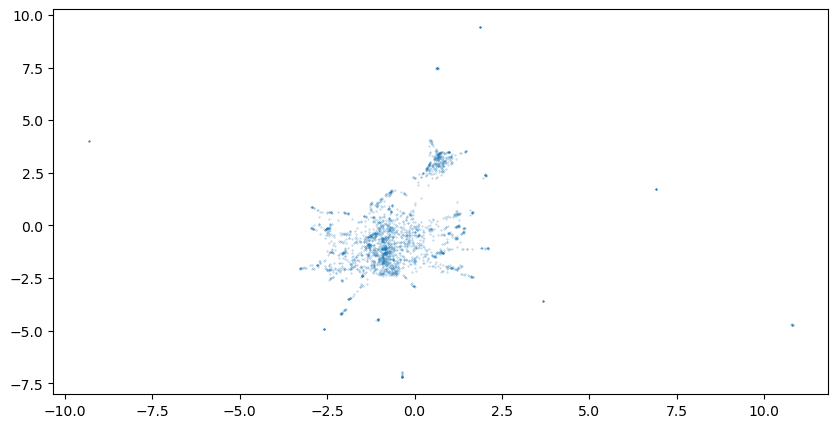

In [151]:
plt.figure(figsize = (10,5))
plt.scatter(reduced_embedding_Frames[:,0],reduced_embedding_Frames[:,1],0.1, alpha =0.5)
# plt.ylim(-2,2)
# plt.xlim(-4,4)

## Creating Frames Network

Building a near neighbors network of categories, and merge them according to the clusters in network.

In [163]:
p_w_D = pairwise_distances(reduced_embedding_Frames)

In [164]:
nearest_neighbor = np.argsort(pairwise_distances(reduced_embedding_Frames), axis = 1)[:,1:]

In [165]:
means = np.mean(pairwise_distances(reduced_embedding_Frames), axis=1) # compute the mean distance of each category to the others

In [167]:
means

array([3.341522 , 3.669346 , 4.7208424, ..., 3.112305 , 4.356471 ,
       3.7396116], dtype=float32)

In [183]:
G = igraph.Graph()

In [184]:
st = datetime.datetime.now()
G.add_vertices(len(nearest_neighbor))
for i in range(len(nearest_neighbor)):
    for j in nearest_neighbor[i]:
        if p_w_D[i][j] <= means[i]/4:
            G.add_edge(i, j, weight = p_w_D[i][j])
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)

RUN TIME: 0:06:16.959863


In [185]:
st = datetime.datetime.now()
part = la.find_partition(G, la.ModularityVertexPartition);
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)

RUN TIME: 0:00:00.063089


In [246]:
TF_IDF_mean = np.mean(TF_IDF_df,axis = 1)

In [254]:
st = datetime.datetime.now()
for i in range(len(G.vs)):
    G.vs[i]['Initial_Frames'] = ' '.join(frame_df.iloc[i][:3].astype(str).to_list())
    for cl in range(len(part)):
        if i in part[cl]:
            G.vs[i]['Relabelled_Category'] = cl
            break
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)
G.vs['Relabelled_Category'], G.vs['Initial_Frames']

RUN TIME: 0:00:03.949213


([0,
  11,
  1,
  1,
  14,
  24,
  3,
  0,
  7,
  12,
  4,
  7,
  5,
  29,
  5,
  1,
  24,
  0,
  1,
  1,
  3,
  17,
  0,
  0,
  5,
  14,
  3,
  1,
  0,
  14,
  0,
  4,
  29,
  23,
  1,
  3,
  5,
  1,
  6,
  12,
  0,
  3,
  1,
  12,
  3,
  11,
  0,
  0,
  0,
  8,
  2,
  2,
  30,
  0,
  5,
  2,
  6,
  3,
  0,
  3,
  3,
  3,
  24,
  1,
  0,
  6,
  0,
  4,
  3,
  2,
  24,
  23,
  6,
  1,
  3,
  0,
  15,
  4,
  4,
  3,
  5,
  24,
  0,
  1,
  3,
  14,
  10,
  0,
  1,
  11,
  14,
  3,
  0,
  0,
  24,
  3,
  9,
  1,
  0,
  29,
  15,
  3,
  2,
  17,
  0,
  0,
  17,
  29,
  2,
  0,
  9,
  0,
  0,
  0,
  35,
  0,
  15,
  5,
  21,
  0,
  14,
  30,
  3,
  24,
  0,
  16,
  29,
  18,
  17,
  14,
  25,
  20,
  8,
  9,
  8,
  3,
  2,
  32,
  9,
  1,
  6,
  6,
  13,
  6,
  36,
  2,
  5,
  15,
  8,
  5,
  18,
  8,
  7,
  28,
  1,
  18,
  14,
  2,
  4,
  16,
  4,
  3,
  27,
  4,
  7,
  7,
  27,
  7,
  17,
  17,
  3,
  8,
  4,
  4,
  10,
  13,
  14,
  2,
  24,
  10,
  6,
  28,
  7,
  7,
  3,
  28,
  4,
  

In [255]:
G.write_graphml('Networks/Initial_Frame_Networks.graphml')

In [228]:
part[0]

[0,
 7,
 17,
 22,
 23,
 28,
 30,
 40,
 46,
 47,
 48,
 53,
 58,
 64,
 66,
 75,
 82,
 87,
 92,
 93,
 98,
 104,
 105,
 109,
 111,
 112,
 113,
 115,
 119,
 124,
 189,
 190,
 206,
 217,
 219,
 229,
 230,
 234,
 239,
 240,
 294,
 295,
 296,
 299,
 301,
 304,
 305,
 306,
 315,
 317,
 319,
 321,
 324,
 326,
 327,
 336,
 342,
 344,
 347,
 350,
 353,
 360,
 361,
 367,
 372,
 373,
 391,
 397,
 403,
 407,
 409,
 411,
 413,
 417,
 421,
 426,
 427,
 428,
 437,
 448,
 450,
 458,
 464,
 481,
 489,
 500,
 515,
 525,
 526,
 529,
 540,
 541,
 549,
 550,
 560,
 570,
 572,
 573,
 579,
 604,
 628,
 635,
 636,
 639,
 651,
 654,
 655,
 656,
 664,
 665,
 677,
 679,
 684,
 690,
 695,
 705,
 714,
 721,
 743,
 746,
 748,
 751,
 761,
 762,
 763,
 780,
 793,
 796,
 800,
 803,
 818,
 833,
 851,
 853,
 859,
 867,
 871,
 872,
 874,
 875,
 881,
 882,
 884,
 886,
 903,
 909,
 941,
 942,
 948,
 951,
 953,
 957,
 960,
 965,
 971,
 973,
 981,
 999,
 1000,
 1011,
 1028,
 1029,
 1031,
 1034,
 1062,
 1070,
 1086,
 1095,
 1124

In [135]:
tt = 0
for i in G.clusters():
    tt+=1
    print(len(i))# Showing the size of each clusters
print(tt) # Showing the total number of merged topics

1554
338
24
15
3
18
50
9
32
23
26
7
17
21
21
14
1
11
8
15
11
13
6
7
1
3
5
7
5
1
30


In [187]:
# Creating a list to label each frames
emerged_labels = []
for i in range(len(Frames_Embeddings)):
    for j in range(len(part)):
        if i in part[j]:
            emerged_labels.append(j)
            break

In [188]:
len(emerged_labels)

2266

In [190]:
frame_df = pd.read_csv('Frames/Initial_Frames_30_Words.csv', index_col=0)

In [192]:
frame_df['updated_Labels'] = emerged_labels

In [193]:
frame_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,updated_Labels
2016/08/06_0,récord,consiguió,escalação,maravilhosa,suécia,confira,paula,basquete,saiu,medalla,...,eua,decision,wins,olympic,debut,opposta,cominciare,allsvenskan,slovacca,0
2016/08/06_1,pistol,sacrificado,basilio,300,formación,vault,10m,comenta,loving,air,...,deporte,record,frase,desiste,significado,casa,vinh,xuan,hoang,11
2016/08/06_2,brian,seleção,ksksjsksm,brasileira,woah,melhor,individual,deporte,foes,enaltece,...,cuchar,pegando,baile,dream,team,aribba,cuchara,goooooooooooooooollll,goooooooooooooooollllll,1
2016/08/06_3,inteiro,crush,brasil,preliminary,result,bola,match,women,mão,handebol,...,gooooooooooooooooolllllllllllllll,goooooooooooooooollllll,goooooooooooooooolllllll,goooooooooooooooollllllll,goooooooooooooooolllllllll,goooooooooooooooollllllllll,gooooooooooooooooolllllllllll,gooooooooooooooool,goooooooooooooooollllllllllll,1
2016/08/06_4,paula,pareto,medalla,emoción,mujer,ganó,argentina,ganar,felicitaciones,otp,...,capítulo,boys,brasileiros,sério,casa,vida,win,melhor,brasil,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016/08/24_187,labore,ぷーる,laborde,bff,miris,おかえりなさい,vía,wow,gooooooooooooooooooooooolllllllllll,gooooooooooooooooooooooollllll,...,gooooooooooooooooooooookokokkkoollldbxjgdichdkdb,gooooooooooooooooooooooooold,goooooooooooooooooooooooooolll,gooooooooooooooooooooooooool,gooooooooooooooooooooooooollllllllllllllllllll...,gooooooooooooooooooooooooollllllllllllllllllll...,gooooooooooooooooooooooooollllllllllllllllllll...,gooooooooooooooooooooooooollll,goooooooooooooooooooooooool,4
2016/08/24_188,rss,goooooooooooooooooooooooo,goooooooooooooooooooooooollllllllllllllll,goooooooooooooooooooooooolllllllllllll,goooooooooooooooooooooooolllll,goooooooooooooooooooooooolll,gooooooooooooooooooooooool,gooooooooooooooooooooooooal,gooooooooooooooooooooooolllllllllllllllllllllll,goooooooooooooooooooooooolllllllllllllllllllll...,...,goooooooooooooooooooooooooolllllllllllllllllll...,goooooooooooooooooooooooooollllllllllllllllllll,goooooooooooooooooooooooooolllllllllllllllll,goooooooooooooooooooooooooolllllllllllll,goooooooooooooooooooooooooollllllllll,goooooooooooooooooooooooooolllll,gooooooooooooooooooooooooold,goooooooooooooooooooooooooolll,gooooooooooooooooooooooooool,5
2016/08/24_189,college,99end,frogs,horned,tcu,virginia,colosseum,navy,women,syracuse,...,boise,95end,ohio,arch,infant,99e,primary,tech,jacket,4
2016/08/24_190,rss,ssmanian61,goooooooooooooooooooooolllllllllll,goooooooooooooooooooooooollllllllllllllll,goooooooooooooooooooooooolllllllllllll,goooooooooooooooooooooooolllll,goooooooooooooooooooooooolll,gooooooooooooooooooooooool,gooooooooooooooooooooooooal,goooooooooooooooooooooooo,...,goooooooooooooooooooooooooolllllllllllllllllll...,goooooooooooooooooooooooooolllllllllllllllllll...,goooooooooooooooooooooooooollllllllllllllllllll,goooooooooooooooooooooooooolllllllllllllllll,goooooooooooooooooooooooooolllllllllllll,goooooooooooooooooooooooooollllllllll,goooooooooooooooooooooooooolllll,gooooooooooooooooooooooooold,goooooooooooooooooooooooooolll,5


## Updating Labels

In [195]:
rio16 = pd.read_csv("Dataset/rio16_Sports_text_time_Ctgry.csv", lineterminator='\n', index_col = 0 )

In [206]:
rio16

,_id,text,created_at,Category
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06,2016/08/06_148
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06,-1
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06,2016/08/06_210
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06,-1
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06,-1
...,...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24,2016/08/24_43
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24,-1
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24,-1
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24,2016/08/24_41


In [211]:
# Updating the Category
st = datetime.datetime.now()
for i in rio16.index:
    if rio16.at[i, 'Category'] != -1:
        rio16.at[i, 'New_Category'] = int(frame_df['updated_Labels'][rio16.at[i, 'Category']])
    else:
        rio16.at[i, 'New_Category'] = int(-1)
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)
rio16

RUN TIME: 0:05:32.327974


,_id,text,created_at,Category,New_Category
0,{'$oid': '57a659236b3d4354b4201578'},The Aussie women's basketball team in a real b...,2016/08/06,2016/08/06_148,8.0
1,{'$oid': '57a659236b3d4354b4201579'},¡Orgullosos de los deportistas,2016/08/06,-1,-1.0
2,{'$oid': '57a659236b3d4354b420157a'},Women's wins 1st Olympic match EVER by 48 p...,2016/08/06,2016/08/06_210,17.0
3,{'$oid': '57a659236b3d4354b420157b'},"When someone tells you ""you can't"". Turn aro...",2016/08/06,-1,-1.0
4,{'$oid': '57a659236b3d4354b420157c'},"Vendo esse Hassan chegando, da até medo",2016/08/06,-1,-1.0
...,...,...,...,...,...
14694485,{'$oid': '57bdbae96b3d43330cc5115f'},Back to school.......schools of squid that i...,2016/08/24,2016/08/24_43,5.0
14694486,{'$oid': '57bdbaeb6b3d43330cc51160'},happening not in not a - we,2016/08/24,-1,-1.0
14694487,{'$oid': '57bdbaeb6b3d43330cc51161'},''I learned all about life with a ball at my...,2016/08/24,-1,-1.0
14694488,{'$oid': '57bdbaec6b3d43330cc51162'},"Errol Spence will KO Keef Thurman, Danny Gar...",2016/08/24,2016/08/24_41,6.0


In [212]:
np.unique(rio16['New_Category'].to_numpy())

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40., 41., 42., 43.])

In [213]:
np.bincount(rio16['New_Category'].astype(int).to_numpy()+1) # Number of tweets in each category

array([8668030,  748203,  734527,  306253,  633725,  770003,  267571,
        278081,  208657,  171722,  115381,  232975,  138913,  221094,
        116139,   81370,   68424,   90232,   33890,   31632,  106590,
         20414,   62891,   42188,   29839,  129459,   47936,   43275,
         18479,    8218,    8359,   36072,   16292,   19983,   34014,
         18978,    7086,   10081,   17168,   32867,   20158,   15488,
         14405,    6568,     268])

In [214]:
rio16['New_Category'] = rio16['New_Category'].astype(int)

In [215]:
rio16.to_csv('Dataset/rio16_Sports_relabelled_2.csv')

In [216]:
rio16['New_Category'].to_csv('Dataset/New_label.csv')

# Second TF-IDF

Run the second TF-IDF base on the updated labels.

In [217]:
final_labels = np.unique(rio16['New_Category'].to_numpy())

In [218]:
final_labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [219]:
texts_in_clusters_2 = []
for i in range(1,len(final_labels)):
    texts_in_clusters_2.append(''.join(rio16['text'][rio16['New_Category']==i-1].astype(str).to_list()))
texts_in_clusters_2.append(''.join(rio16['text'][rio16['New_Category']==-1].astype(str).to_list()))

In [223]:
X = vectorizer.fit_transform(texts_in_clusters_2)

/root/miniconda3/envs/rapids-22.08/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'baiknya', 'berkali', 'daren', 'hadn', 'herse', 'himse', 'itse', 'kali', 'kurangnya', 'mata', 'mayn', 'mightn', 'mustn', 'myse', 'needn', 'olah', 'oughtn', 'quelqu', 'sekurang', 'setidak', 'shan', 'tama', 'tidaknya', 'хотел', 'กล', 'กว', 'คร', 'งจาก', 'งน', 'งแต', 'ดเผย', 'นการ', 'พร', 'ยว', 'ยวก', 'ระหว', 'วง', 'วน', 'วม', 'วย', 'หน', 'หร', 'หล', 'อง', 'องจาก', 'อน', 'อม', 'อย', 'าง', 'างๆ', 'าน', 'าว', 'าหร', 'าให', 'เข', 'เช', 'เด', 'เน', 'เป', 'เพ', 'เม', 'เร', 'เห', 'แต', 'แล', 'แห', 'ให', 'ได', 'ไม', 'ไว', '가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다',

In [225]:
final_frames = pd.DataFrame(vectorizer.get_feature_names_out()[np.argsort(X.toarray(), axis = 1)[:-1,:-16:-1]])

In [227]:
final_frames.to_csv('Frames/Final_Frames.csv')